# R-CNN with RESNET 50 - with KFCV

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display

import config
from config import Config
import util

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
#from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from numpy import save, load



In [2]:
"""
Setting Custom Configuration
"""

class WiderFaceConfig(Config):
    """Configuration for training on WIDER face dataset.
    WiderFaceConfig classs derives from the base Config class and overrides configurations specific
    to the WIDER Face dataset.
    """
    NAME = "wider_face_experiment1"
    WEIGHTS = "imagenet"
    LEARNING_RATE = 0.0001
    ROTATION_RANGE_IMAGEGEN = 90
    DTYPE_IMAGEGEN = 'uint8'
    MONITOR = 'val_loss'
    SAVE_FREQ = 'epoch'
    STEPS_PER_EPOCH = 10
    TOTAL_EPOCHS = 1000
    VALIDATION_STEPS = 2
    NUM_CLASSES = 2
    
config = WiderFaceConfig()    

In [ ]:
config = WiderFaceConfig()

In [ ]:
#setting image and annotation paths
#image_path = "WIDER FACE/WIDER_train/images"
#annot_path = "WIDER FACE/wider_face_split"

image_path = "../WIDER FACE/wider_train_final_3919/images"
annot_path = "../WIDER FACE/wider_train_final_3919/annots"

In [ ]:
# draw rectangles on first image of the dataset using anotaions upto 9(<10)
for e,i in enumerate(os.listdir(annot_path)):
    if e < 2:
        filename = i.split(".")[0]+".jpg"
        #print(filename)
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_ANYCOLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
        #plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), thickness = 2)
        plt.figure()
        plt.imshow(img)


In [ ]:
def selective_search(image_path, image_name):
    """
    perform Fast Selective Search for the passed image
    """
    
    cv2.setUseOptimized(True)

    img = cv2.imread(os.path.join(image_path, image_name))

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    return ssresults

# Image Preprocessing & Train-Test data preparation  

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
for e,i in enumerate(os.listdir(annot_path)):
    try:
        #if e>1001:
        #    break
        filename = i.split(".")[0]+".jpg"
        print(e,filename)
        image = cv2.imread(os.path.join(image_path,filename))
        df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
        gtvalues=[] 
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
             # appending groundtruth values
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ssresults = selective_search(image_path, filename)
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):#
            if e < config.MAX_REGIONS and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = util.calculate_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (config.IMAGE_MIN_DIM,config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
# X_new.shape

In [ ]:
save('X_new_3919_4.npy', X_new)
save('y_new_3919_4.npy', y_new)

In [ ]:
#X_new = load('X_new_3919.npy')
#y_new = load('y_new_3919.npy')

In [ ]:
X_new.shape

In [ ]:
y_new.shape

In [7]:
X_new_1 = load('X_new_3919_1.npy')
X_new_2 = load('X_new_3919_2.npy')
X_new_3 = load('X_new_3919_3.npy')
X_new_4 = load('X_new_3919_4.npy')

MemoryError: Unable to allocate 9.13 GiB for an array with shape (9799071744,) and data type uint8

In [2]:
X_temp1 = load('X_new_temp1.npy')
X_temp2 = load('X_new_temp2.npy')

In [3]:
X_new = np.concatenate((X_temp1, X_temp2), axis=0)

In [8]:
save('X_new_3919.npy', X_new)

In [4]:
X_new.shape

(160223, 224, 224, 3)

In [6]:
X_temp1

array([[[[ 14,  10,  15],
         [ 14,  10,  15],
         [ 14,  10,  15],
         ...,
         [ 67,  63,  69],
         [ 67,  63,  69],
         [ 67,  63,  69]],

        [[ 14,  10,  15],
         [ 14,  10,  15],
         [ 14,  10,  15],
         ...,
         [ 69,  65,  71],
         [ 69,  65,  71],
         [ 69,  65,  71]],

        [[ 14,  10,  15],
         [ 14,  10,  15],
         [ 14,  10,  15],
         ...,
         [ 80,  76,  81],
         [ 80,  76,  81],
         [ 80,  76,  81]],

        ...,

        [[130, 129, 131],
         [130, 129, 131],
         [130, 129, 131],
         ...,
         [195, 183, 183],
         [195, 183, 183],
         [195, 183, 183]],

        [[122, 122, 126],
         [122, 122, 126],
         [122, 122, 126],
         ...,
         [191, 181, 181],
         [191, 181, 181],
         [191, 181, 181]],

        [[120, 121, 125],
         [120, 121, 125],
         [120, 121, 125],
         ...,
         [191, 181, 181],
        

# Model Formation and Training

In [11]:
from keras.models import Sequential
model_final = Sequential()

pretrained_resnet= tf.keras.applications.ResNet50(include_top=False,
                                                     input_shape=(224,224,3),
                                                     pooling='avg',
                                                     classes=2,
                                                     weights='imagenet')

for each_layer in pretrained_resnet.layers[:143]:
        each_layer.trainable=False

model_final.add(pretrained_resnet)

In [5]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model_final.add(Flatten())
model_final.add(Dense(512, activation='relu'))
model_final.add(Dense(2, activation='softmax'))

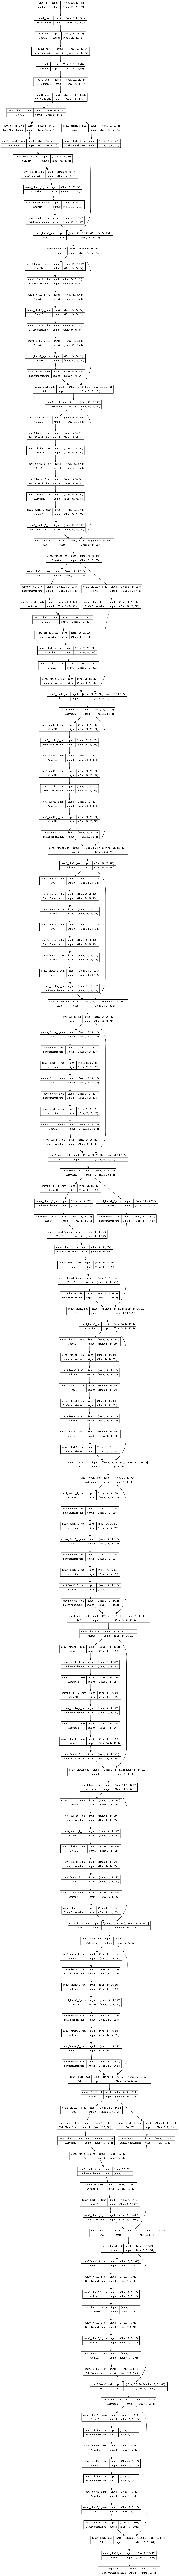

In [12]:
plot_model(pretrained_resnet, to_file='resnet50_pretrained_plot.png', show_shapes=True, show_layer_names=True)

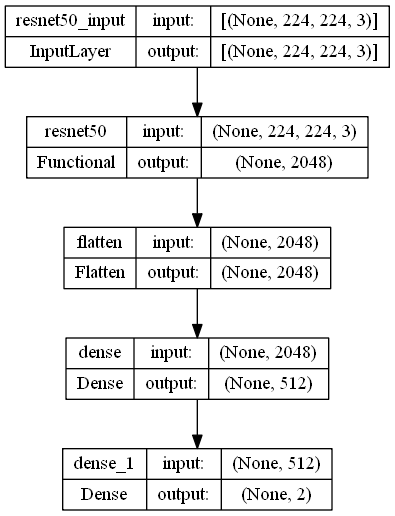

In [6]:
#import visualkeras
#visualkeras.layered_view(model)
plot_model(model_final, to_file='resnet50_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
for i, layer in enumerate(pretrained_resnet.layers):
        print(i, layer.name, "=", layer.trainable)

0 input_4 = False
1 conv1_pad = False
2 conv1_conv = False
3 conv1_bn = False
4 conv1_relu = False
5 pool1_pad = False
6 pool1_pool = False
7 conv2_block1_1_conv = False
8 conv2_block1_1_bn = False
9 conv2_block1_1_relu = False
10 conv2_block1_2_conv = False
11 conv2_block1_2_bn = False
12 conv2_block1_2_relu = False
13 conv2_block1_0_conv = False
14 conv2_block1_3_conv = False
15 conv2_block1_0_bn = False
16 conv2_block1_3_bn = False
17 conv2_block1_add = False
18 conv2_block1_out = False
19 conv2_block2_1_conv = False
20 conv2_block2_1_bn = False
21 conv2_block2_1_relu = False
22 conv2_block2_2_conv = False
23 conv2_block2_2_bn = False
24 conv2_block2_2_relu = False
25 conv2_block2_3_conv = False
26 conv2_block2_3_bn = False
27 conv2_block2_add = False
28 conv2_block2_out = False
29 conv2_block3_1_conv = False
30 conv2_block3_1_bn = False
31 conv2_block3_1_relu = False
32 conv2_block3_2_conv = False
33 conv2_block3_2_bn = False
34 conv2_block3_2_relu = False
35 conv2_block3_3_conv = 

In [ ]:
opt = Adam(learning_rate=config.LEARNING_RATE)

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, 
                    optimizer = opt, 
                    metrics=["accuracy"])

In [ ]:
#from sklearn.preprocessing import LabelBinarizer

In [ ]:
#labelbinarizer = LabelBinarizer()
#make_encoded_results = labelbinarizer.fit_transform(y_new)

In [ ]:
#lenc = util.MyLabelBinarizer()
#Y =  lenc.fit_transform(y_new)

## Train-Test-Validation Split

In [ ]:
#Train-Test-Validation Split
X_train, X_test , y_train, y_test = train_test_split(X_new, y_new, test_size=0.40)
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X_new, target=Y, train_size=0.8, valid_size=0.1, test_size=0.1)

#X_train, X_rem, y_train, y_rem = train_test_split(X_new, Y, train_size=0.60)
#test_size = 0.5
#X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=test_size)

In [ ]:
#print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

In [ ]:
# trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
# train_data = trdata.flow(x=X_train, y=y_train)
# vldata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
# valid_data = vldata.flow(x=X_valid, y=y_valid)
#tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
#test_data = tsdata.flow(x=X_test, y=y_test)

In [ ]:
print(X_test.shape)

In [ ]:
print(y_test.shape)

In [ ]:
labelbin_test = util.MyLabelBinarizer()
y_test = labelbin_test.fit_transform(y_test)

## k-Fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# ===============Stratified K-Fold======================

skf = KFold(n_splits=3, shuffle=True)
skf.get_n_splits(X_train, y_train)
fold_var = 1

TRAIN_ACCURACY = []
TRAIN_LOSS = []
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for train_index, val_index in skf.split(X_train, y_train):
    print("---Starting K-fold validation Iteration - "+str(fold_var)+"---")
    
    X_train_fold, y_train_fold = np.take(X_train, train_index, 0), np.take(y_train, train_index, 0)    
    X_valid_fold, y_valid_fold = np.take(X_train, val_index, 0), np.take(y_train, val_index, 0) 
    
    #X_train, y_train = X_new.iloc[train_index], Y.iloc[train_index]
    #X_valid, y_valid = X_new.iloc[val_index], Y.iloc[val_index]
    
    labelbin = util.MyLabelBinarizer()
    y_train_fold_bin = labelbin.fit_transform(y_train_fold)
    y_valid_fold_bin =  labelbin.fit_transform(y_valid_fold)

    #initialize ImageDataGenerators 
    train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                       vertical_flip=True, 
                                       rotation_range=config.ROTATION_RANGE_IMAGEGEN, 
                                       dtype=config.DTYPE_IMAGEGEN)
    
    validation_datagen = ImageDataGenerator(horizontal_flip=True, 
                                            vertical_flip=True, 
                                            rotation_range=config.ROTATION_RANGE_IMAGEGEN, 
                                            dtype=config.DTYPE_IMAGEGEN)
    
    train_data = train_datagen.flow(x=X_train_fold, y=y_train_fold_bin)
    
    valid_data = validation_datagen.flow(x=X_valid_fold, y=y_valid_fold_bin)
    
    model_name = "exp4_rcnn_vgg16_kfcv_"+str(fold_var)+".h5"
    checkpoint = ModelCheckpoint(model_name, monitor=config.MONITOR, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=config.SAVE_FREQ)
    early = EarlyStopping(monitor=config.MONITOR, min_delta=config.MIN_DELTA, patience=config.PATIENCE, verbose=1, mode='auto')

    # fit model
    #history = model.fit(train_generator, epochs=epoch)
    history = model_final.fit(x= train_data, steps_per_epoch= config.STEPS_PER_EPOCH, epochs= config.TOTAL_EPOCHS, validation_data= valid_data, validation_steps=config.VALIDATION_STEPS, callbacks=[checkpoint,early])

    #score = model_final.evaluate(X_test, y_test, verbose=1)
    #predictions = model_final.predict(validation_generator, verbose=1)
    #y_predictions = np.argmax(predictions, axis=1)
    #true_classes = validation_generator.classes
    
    TRAIN_ACCURACY.append(history.history['accuracy'])
    TRAIN_LOSS.append(history.history['loss'])
    VALIDATION_ACCURACY.append(history.history['val_accuracy'])
    VALIDATION_LOSS.append(history.history['val_loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    # evaluate validation performance
    #print("***Performance on Validation data***")
    #val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

In [ ]:
save('train_acc.npy', np.array(TRAIN_ACCURACY))
save('train_loss.npy', np.array(TRAIN_LOSS))
save('val_acc.npy', np.array(VALIDATION_ACCURACY))
save('val_loss.npy', np.array(VALIDATION_LOSS))

In [7]:
TRAIN_ACCURACY = load('3100_train_acc.npy', allow_pickle=True)
TRAIN_LOSS = load('3100_train_loss.npy', allow_pickle=True)
VALIDATION_ACCURACY = load('3100_val_acc.npy', allow_pickle=True)
VALIDATION_LOSS = load('3100_val_loss.npy',allow_pickle=True)

In [4]:
print(VALIDATION_ACCURACY)

[list([0.84375, 0.90625, 0.875, 0.84375, 0.890625, 0.953125, 0.96875, 0.96875, 0.96875, 0.984375, 0.953125, 1.0, 1.0, 1.0, 0.96875, 0.953125, 0.921875, 0.9375, 0.96875, 0.984375, 0.984375, 0.984375, 0.96875, 0.921875, 0.984375, 1.0, 0.9375, 0.953125, 1.0, 0.953125, 1.0, 0.96875, 0.96875, 1.0, 0.984375, 0.921875, 0.96875, 1.0, 0.953125, 0.984375, 1.0, 0.96875, 0.984375, 0.9375, 0.984375, 0.96875, 0.984375, 0.96875, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.921875, 1.0, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 0.96875, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 0.9375, 1.0, 0.96875, 1.0, 0.953125, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 1.0, 0.953125, 0.984375, 0.984375, 0.96875, 

In [ ]:
# checkpoint = ModelCheckpoint("exp4_rcnn_vgg16_kfcv_1.h5", monitor=config.MONITOR, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=config.SAVE_FREQ)
# early = EarlyStopping(monitor=config.MONITOR, min_delta=config.MIN_DELTA, patience=config.PATIENCE, verbose=1, mode='auto')

In [ ]:
#history = model_final.fit(x= train_data, steps_per_epoch= config.STEPS_PER_EPOCH, epochs= config.TOTAL_EPOCHS, validation_data= valid_data, validation_steps=config.VALIDATION_STEPS, callbacks=[checkpoint,early])

# Visualization of Training Results

In [ ]:
from keras.models import load_model
model_final = load_model('exp4_rcnn_vgg16_kfcv_3.h5')


In [ ]:
print(y_test.shape)

In [ ]:
# Generate generalization metrics
score = model_final.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

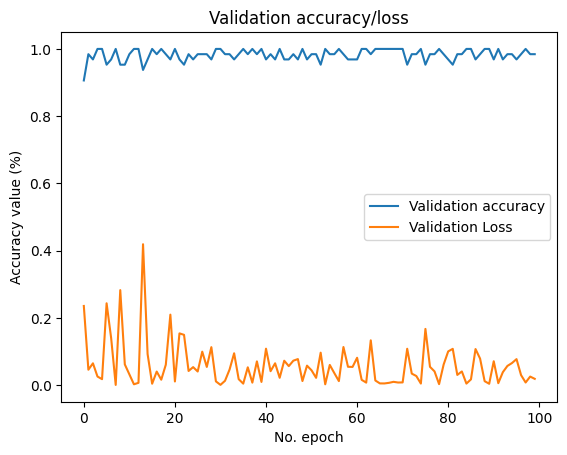

In [9]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of first Iteration
plt.plot(VALIDATION_ACCURACY[0])
plt.plot(VALIDATION_LOSS[0])
plt.title('Validation accuracy/loss')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation accuracy","Validation Loss"])
plt.show()

In [ ]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of second Iteration
plt.plot(VALIDATION_ACCURACY[1])
plt.plot(VALIDATION_LOSS[1])
plt.title('Validation accuracy/loss')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation accuracy","Validation Loss"])
plt.show()

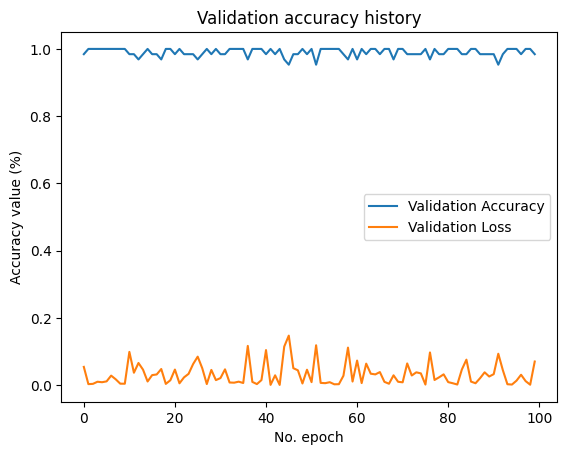

In [8]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of thirs iteration
plt.plot(VALIDATION_ACCURACY[2])
plt.plot(VALIDATION_LOSS[2])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation Accuracy", "Validation Loss"])
plt.show()

In [ ]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()
#plt.savefig('chart loss.png')

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
validation_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
test_data = validation_datagen.flow(x=X_test, y=y_test)

In [ ]:
# Generate generalization metrics
score = model_final.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Prediction

In [ ]:
#model_final = load_model('exp4_rcnn_vgg16_1.h5')

In [ ]:
im = X_test[40]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("face")
else:
    print("not face")

In [ ]:
rects = []

filename = '232.jpg'
img = cv2.imread(os.path.join(image_path, filename))
ssresults = selective_search(image_path, filename)
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < config.MAX_REGIONS:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            rects.append([x, y, x+w, y+h])
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 127), 2, cv2.LINE_AA)
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

In [ ]:
filename = '232.jpg'
img = cv2.imread(os.path.join(image_path, filename))
imout2 = img.copy()

rects_ = np.array(rects)
pick = util.non_max_suppression_fast(rects_, overlapThresh=0.40) #original = 0.65

# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(imout2, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
plt.figure()
plt.imshow(cv2.cvtColor(imout2, cv2.COLOR_BGR2RGB))